In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH
START = '2013-01-01'
END = '2023-03-01'
DATA_STORE = '../00_datasets/data_store_38.h5'

ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [5]:
# with pd.HDFStore(DATA_STORE) as store:
#     prices = (store['quandl/wiki/prices']
#               .loc[idx[START:END, :], ohlcv]
#               .rename(columns=lambda x: x.replace('adj_', ''))
#               .assign(volume=lambda x: x.volume.div(1000))
#               .swaplevel()
#               .sort_index())

#     stocks = (store['us_equities/stocks']
#               .loc[:, ['marketcap', 'ipoyear', 'sector']])

In [36]:
with pd.HDFStore(DATA_STORE) as store:
    stock_prices = store['stocks/prices/daily']
    etf_prices = store['etfs/prices/daily']
    stock_metadata = store['stocks/base_fundementals']
    etf_metadata = store['etfs/base_fundementals']

In [13]:
stock_prices.head()

open     high      low    close  adjusted_close     volume
     date                                                                     
AAPL 1980-12-12  28.7392  28.8736  28.7392  28.7392          0.0997  469033600
     1980-12-15  27.3728  27.3728  27.2608  27.2608          0.0946  175884800
     1980-12-16  25.3792  25.3792  25.2448  25.2448          0.0876  105728000
     1980-12-17  25.8720  26.0064  25.8720  25.8720          0.0898   86441600
     1980-12-18  26.6336  26.7456  26.6336  26.6336          0.0924   73449600

In [14]:
etf_prices.head()

open     high      low    close  adjusted_close   volume
    date                                                                   
SPY 1993-01-29  43.8595  43.9688  43.7500  43.9375         25.2275  1003200
    1993-02-01  43.9688  44.2500  43.9688  44.2500         25.4069   480500
    1993-02-02  44.2188  44.3750  44.1250  44.3438         25.4607   201300
    1993-02-03  44.4063  44.8438  44.3750  44.8125         25.7299   529400
    1993-02-04  44.9688  45.0938  44.8750  45.0000         25.8375   531500

In [34]:
prices = pd.concat([stock_prices, etf_prices])

In [15]:
stock_metadata.head()

AAPL  General  Code                    AAPL
               Type            Common Stock
               Name               Apple Inc
               Exchange              NASDAQ
               CurrencyCode             USD
dtype: object

In [16]:
etf_metadata.head()

SPY  General  Code                               SPY
              Type                               ETF
              Name            SPDR S&P 500 ETF Trust
              Exchange                     NYSE ARCA
              CurrencyCode                       USD
dtype: object

In [29]:
stocks_sector = pd.DataFrame(stock_metadata.loc[idx[:, 'General', 'Sector']], columns= ['Sector'])
etf_sector = pd.DataFrame(etf_metadata.loc[idx[:, 'General', 'Category']], columns= ['Sector'])

In [33]:
stocks = pd.concat([stocks,etfs])

,Sector
AAPL,Technology
MSFT,Technology
AMZN,Consumer Cyclical
GOOGL,Communication Services
TSLA,Consumer Cyclical
...,...
TVIXF,Trading--Miscellaneous
VIXY,Trading--Miscellaneous
SVXY,Trading--Miscellaneous
SPXL,Trading--Leveraged Equity


## Data Cleaning

In [16]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level=0).size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

In [17]:
# Align price and meta data
stocks = stocks1[~stocks1.index.duplicated() & stocks1.Sector.notnull()]
stocks.Sector = stocks1.Sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

shared = (prices.index.get_level_values(0).unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [18]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4000365 entries, ('A', '1999-11-18') to ('ZTS', '2023-03-01')
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   open            4000365 non-null  float64
 1   high            4000365 non-null  float64
 2   low             4000365 non-null  float64
 3   close           4000365 non-null  float64
 4   adjusted_close  4000365 non-null  float64
 5   volume          4000365 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 199.0+ MB


In [19]:
prices.head()

open     high      low    close  adjusted_close    volume
  date                                                                    
A 1999-11-18  42.8579  47.0966  37.6772  40.2676         24.5145  44733602
  1999-11-19  40.4442  40.5030  37.5006  38.3837         23.3676  10896900
  1999-11-22  38.9135  41.0917  37.7361  41.0917         25.0162   4705100
  1999-11-23  40.0321  41.0917  37.9127  37.9127         23.0809   4274300
  1999-11-24  37.7950  39.5022  37.6772  38.6780         23.5468   3464400

## Compute Rolling Average Dollar Volume

In [20]:
# compute dollar volume to determine universe

prices['volume'] = prices['volume'] / 1000

prices['dollar_vol'] = prices[['adjusted_close', 'volume']].prod(axis=1)



prices['dollar_vol_1m'] = (prices.dollar_vol.groupby(level=0)
                           .rolling(window=21, on=prices.index.get_level_values(1))
                           .mean()).values

prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4000365 entries, ('A', '1999-11-18') to ('ZTS', '2023-03-01')
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             4000365 non-null  float64
 1   high             4000365 non-null  float64
 2   low              4000365 non-null  float64
 3   close            4000365 non-null  float64
 4   adjusted_close   4000365 non-null  float64
 5   volume           4000365 non-null  float64
 6   dollar_vol       4000365 non-null  float64
 7   dollar_vol_1m    3990365 non-null  float64
 8   dollar_vol_rank  3990365 non-null  float64
dtypes: float64(9)
memory usage: 290.6+ MB


## Add Some Basic Factors

In [21]:
## RSI
prices['rsi'] = prices.groupby(level=0).close.apply(RSI)


In [22]:
# ax = sns.distplot(prices.rsi.dropna())
# ax.axvline(30, ls='--', lw=1, c='k')
# ax.axvline(70, ls='--', lw=1, c='k')
# ax.set_title('RSI Distribution with Signal Threshold')
# plt.tight_layout()

In [23]:
## BBANDS BROKE!

In [24]:
# Bollinger Bands
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

prices = (prices.join(prices
                      .groupby(level=0)
                      .close
                      .apply(compute_bb), rsuffix = "_"))

prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)


In [25]:
# fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
# sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
# sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
# plt.tight_layout()

In [26]:
## Average True Range
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices['atr'] = (prices.groupby(level=0, group_keys=False)
                 .apply(compute_atr))

In [27]:
# sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna())

In [28]:
## MACD
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices['macd'] = (prices
                  .groupby(level=0, group_keys=False)
                  .close
                  .apply(compute_macd))

prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    3,983,865.0
mean             0.0
std              1.0
min            -25.2
0.1%            -8.7
1%              -3.4
2%              -2.3
3%              -1.8
4%              -1.5
5%              -1.3
50%              0.0
95%              1.3
96%              1.4
97%              1.6
98%              1.9
99%              2.4
99.9%            4.6
max             15.0
Name: macd, dtype: object

In [29]:
# sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna())

## Compute Lagged Returns

In [30]:
lags = [1, 5, 10, 21, 42, 63]
returns = prices.groupby(level=0).close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')
q = 0.0001

In [31]:
# winsorize outliers
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level=0).close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

In [32]:
# shift lagged returns
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level=0)
                                           [f'return_{lag}d'].shift(t * lag))

In [33]:
## Compute Forward Returns
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level=0)[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [34]:
prices = prices.join(stocks[['Sector']], on=prices.index.get_level_values(0))#.set_index('level_0', append=True).swaplevel(1, 0)

## Create Sector and Dummy Variables

In [35]:
prices.index = prices.index.set_levels([prices.index.levels[0], pd.to_datetime(prices.index.levels[1])])

prices['year'] = prices.index.get_level_values(level=1).year
prices['month'] = prices.index.get_level_values(level=1).month

In [36]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4000365 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZTS', Timestamp('2023-03-01 00:00:00'))
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             4000365 non-null  float64
 1   high             4000365 non-null  float64
 2   low              4000365 non-null  float64
 3   close            4000365 non-null  float64
 4   adjusted_close   4000365 non-null  float64
 5   volume           4000365 non-null  float64
 6   dollar_vol       4000365 non-null  float64
 7   dollar_vol_1m    3990365 non-null  float64
 8   dollar_vol_rank  3990365 non-null  float64
 9   rsi              3993365 non-null  float64
 10  bb_high          3990864 non-null  float64
 11  bb_low           3990757 non-null  float64
 12  atr              3993365 non-null  float64
 13  macd             3983865 non-null  float64
 14  return_1d        3999865 non-null  float64

In [37]:
prices = prices.assign(sector_factor=pd.factorize(prices.Sector, sort=True)[0])

In [38]:
prices.head()

open     high      low    close  adjusted_close     volume  \
  date                                                                        
A 1999-11-18  42.8579  47.0966  37.6772  40.2676         24.5145  44733.602   
  1999-11-19  40.4442  40.5030  37.5006  38.3837         23.3676  10896.900   
  1999-11-22  38.9135  41.0917  37.7361  41.0917         25.0162   4705.100   
  1999-11-23  40.0321  41.0917  37.9127  37.9127         23.0809   4274.300   
  1999-11-24  37.7950  39.5022  37.6772  38.6780         23.5468   3464.400   

                dollar_vol  dollar_vol_1m  dollar_vol_rank  rsi  ...  \
  date                                                           ...   
A 1999-11-18  1.096622e+06            NaN              NaN  NaN  ...   
  1999-11-19  2.546344e+05            NaN              NaN  NaN  ...   
  1999-11-22  1.177037e+05            NaN              NaN  NaN  ...   
  1999-11-23  9.865469e+04            NaN              NaN  NaN  ...   
  1999-11-24  8.157553e+04            NaN              NaN  NaN  ...   

              return_10d_lag5  return_21d_lag5  target_1d  target_5d  \
  date                                                                 
A 1999-11-18              NaN              NaN  -0.046785  -0.007419   
  1999-11-19              NaN              NaN   0.070551   0.006659   
  1999-11-22              NaN              NaN  -0.077364  -0.006679   
  1999-11-23              NaN              NaN   0.020186   0.013011   
  1999-11-24              NaN              NaN   0.003046   0.014490   

              target_10d  target_21d      Sector  year  month  sector_factor  
  date                                                                        
A 1999-11-18    0.005142    0.004396  healthcare  1999     11              6  
  1999-11-19    0.011641    0.006434  healthcare  1999     11              6  
  1999-11-22    0.003664    0.004123  healthcare  1999     11              6  
  1999-11-23    0.011638    0.010142  healthcare  1999     11              6  
  1999-11-24    0.011006    0.012056  healthcare  1999     11              6  

[5 rows x 48 columns]

### Store Data

In [39]:
prices.to_hdf('data.h5', 'model_data/no_dummies')

In [40]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector_factor'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [41]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4000365 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZTS', Timestamp('2023-03-01 00:00:00'))
Columns: 127 entries, open to 10
dtypes: float64(44), object(1), uint8(82)
memory usage: 1.7+ GB


## Store Model Data

In [42]:
prices.to_hdf('data.h5', 'model_data')

## Explore Data

In [43]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

In [44]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [45]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",56020.0,0.001162,0.014497,-0.196088,-0.004598,0.001194,0.007560,0.109097
"(30, 70]",1072041.0,0.000076,0.011774,-0.196088,-0.004444,0.000375,0.005253,0.109097
"(70, 100]",80316.0,-0.000791,0.012075,-0.196088,-0.004604,0.000000,0.003849,0.104995


-3.11% (0.00%)


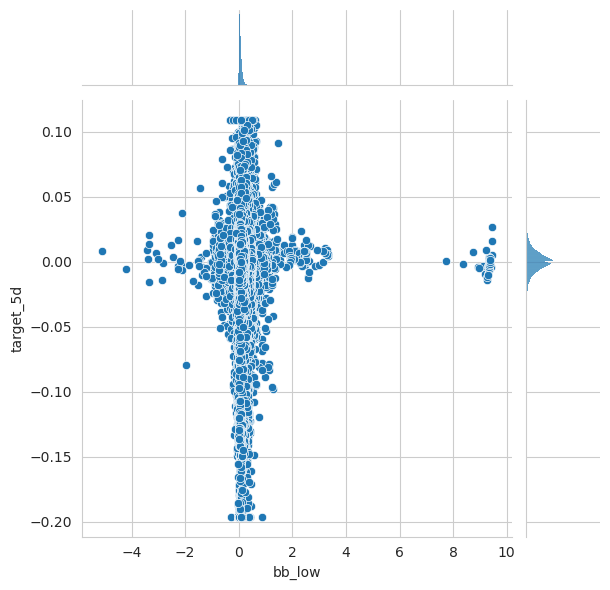

In [46]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

3.84% (0.00%)


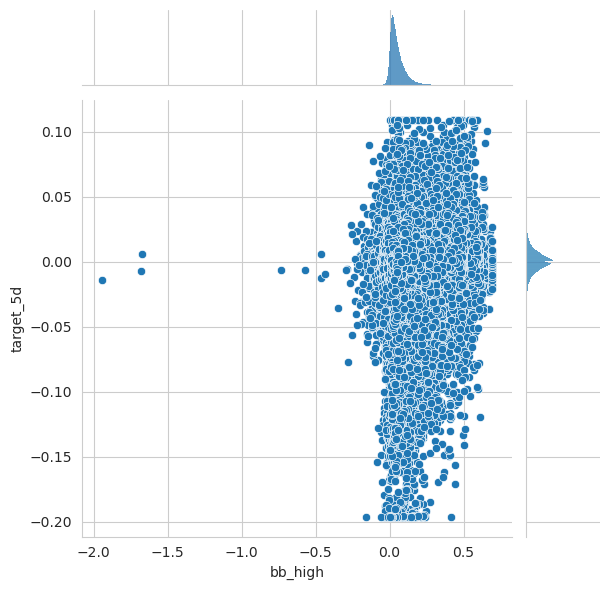

In [47]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

-0.77% (0.00%)


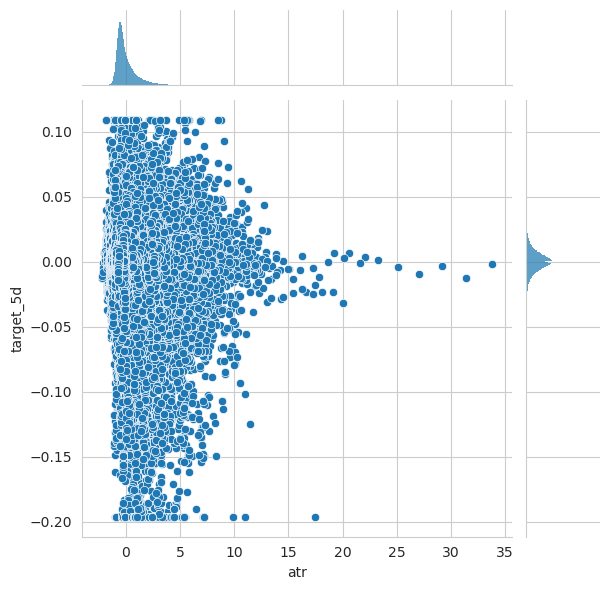

In [48]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

-2.43% (0.00%)


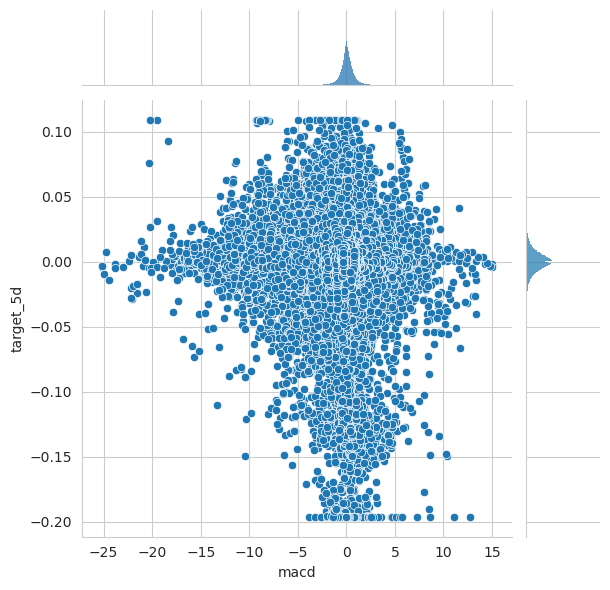

: 

In [49]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')